# Malaria Disease Prediction from CT Cell Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirkasraamini","key":"e9d3dc0c7d67fe619449aba85338297b"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 673M/675M [00:13<00:00, 76.9MB/s]
100% 675M/675M [00:13<00:00, 52.3MB/s]


In [ ]:
mkdir destination1111

In [ ]:
!unzip /content/cell-images-for-detecting-malaria.zip -d destination1111

In [ ]:
import shutil
shutil.rmtree('/content/destination1111/cell_images/cell_images')

## Creating Train / Val / Test folders

In [ ]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = '/content/destination1111/cell_images'
classes_dir = ['Parasitized', 'Uninfected']

val_ratio = 0.15
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)
    os.makedirs(root_dir +'test/' + cls)


  # Creating partitions of the data after shuffeling
    src = root_dir + "/" +cls   # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

  # Copy-pasting images
    for name in train_FileNames:
        shutil.move(name, root_dir +'train/' + cls)

    for name in val_FileNames:
        shutil.move(name, root_dir +'val/' + cls)

    for name in test_FileNames:
        shutil.move(name, root_dir +'test/' + cls)

Total images:  13780
Training:  11024
Validation:  2067
Testing:  689
Total images:  13780
Training:  11024
Validation:  2067
Testing:  689


### Importing the libraries

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.__version__

'2.6.0'

#### Converting the images to arrays, rescaling them, and creating the training, val and test sets.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('/content/destination1111/cell_imagestrain',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 22046 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/destination1111/cell_imagestest',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 1378 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory('/content/destination1111/cell_imagesval',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 4134 images belonging to 2 classes.


## Part 1 - Building the deep neural network Model 

### Initialising the CNN

In [ ]:
import keras,os
import numpy as np

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation

In [ ]:
model = Sequential()


model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


In [ ]:
model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

### Definig the optimizer and compiling the model

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

### Part 2 - Initialising the Checkpoint and training the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
filepath = '/content/best_Model_weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='auto')

In [ ]:
results = model.fit(x=training_set, validation_data= val_set, epochs=15,callbacks=checkpoint)

Epoch 1/15
689/689 [==============================] - 504s 670ms/step - loss: 0.3662 - accuracy: 0.8240 - val_loss: 0.1505 - val_accuracy: 0.9545

Epoch 00001: val_accuracy improved from -inf to 0.95452, saving model to /content/best_Model_weights.h5
Epoch 2/15
689/689 [==============================] - 448s 649ms/step - loss: 0.1442 - accuracy: 0.9540 - val_loss: 0.1515 - val_accuracy: 0.9569

Epoch 00002: val_accuracy improved from 0.95452 to 0.95694, saving model to /content/best_Model_weights.h5
Epoch 3/15
689/689 [==============================] - 448s 649ms/step - loss: 0.1357 - accuracy: 0.9563 - val_loss: 0.1416 - val_accuracy: 0.9565

Epoch 00003: val_accuracy did not improve from 0.95694
Epoch 4/15
689/689 [==============================] - 447s 648ms/step - loss: 0.1288 - accuracy: 0.9589 - val_loss: 0.1600 - val_accuracy: 0.9536

Epoch 00004: val_accuracy did not improve from 0.95694
Epoch 5/15
689/689 [==============================] - 447s 648ms/step - loss: 0.1219 - accu

## Part 3 - Plotting Graphical Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

['Parasitized', 'Uninfected']


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


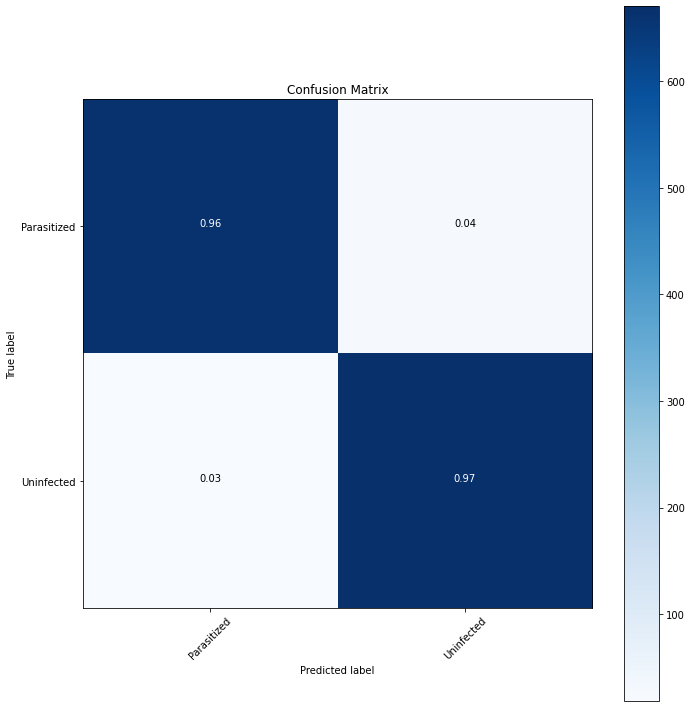

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

target_names = []

for key in training_set.class_indices:

    target_names.append(key)

print(target_names)


Y_pred = model.predict_generator(test_set)

y_pred = np.where(Y_pred>0.5, 1, 0)

print('Confusion Matrix')

cm = confusion_matrix(test_set.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Part 4-Classification report

In [ ]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.where(Y_pred>0.5, 1, 0)
class_labels = list(test_set.class_indices.keys())

In [ ]:
report = classification_report(test_set.classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.97       689
  Uninfected       0.96      0.97      0.97       689

    accuracy                           0.97      1378
   macro avg       0.97      0.97      0.97      1378
weighted avg       0.97      0.97      0.97      1378



# Part 5-Model accuracy and loss graphs

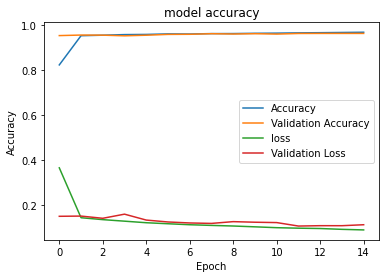

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results.history["accuracy"])
plt.plot(results.history['val_accuracy'])
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# Part 6 - Saving and Loading the model for prediction

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/best_Model_weights.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load json and create model
json_file = open('/content/best_Model_weights.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('best_Model_weights.h5')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(test_set, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 96.73%


###### As we can see, the accuracy of our model on test data is 96.73%. We are going to use transfer learning and train 2 pre-trained models on this dataset and see the results to compare them.

In [ ]:
# from keras.models import model_from_json
# from keras.models import load_model

# # serialize model to JSON
# model_json = model.to_json()
# with open("best_Model_weights.json", "w") as json_file:
#     json_file.write(model_json)

# # serialize weights to HDF5
# model.save_weights("best_Model_weights.h5")

In [ ]:
# # load json and create model
# json_file = open('best_Model_weights.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("best_Model_weights.h5")
# print("Loaded model from disk")

# loaded_model.save('best_Model_weights.hdf5')
# loaded_model=load_model('best_Model_weights.hdf5')

# Part 7 - Deploying the model to Predict a single sample.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)

    print(decode_predictions(prediction, top=3)[0])

classify("./samples/112_malaria.jpg")

#Section 2.1 - Using pre-trained models to train and evaluate.

# Part 1- EfficientNetB2: Initialising the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from keras.models import model_from_json

In [ ]:
pre_trained_model=tf.keras.models.Sequential([
                                              
  tf.keras.layers.InputLayer((224,224,3)),
  tf.keras.applications.EfficientNetB2(include_top=False,weights= 'imagenet', input_shape=(224,224,3)),
  
  tf.keras.layers.GlobalAveragePooling2D(),
  
  tf.keras.layers.Dense(512,activation='relu'),
  #tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Dense(1024,activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 9,016,314
Trainable params: 8,948,739
Non-trainable params: 67,575
_________________________________________________________________


# Part 2- Compiling and trainig the model

In [ ]:
pre_trained_model.compile(optimizer =tf.keras.optimizers.Adam(0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
filepath = '/content/best_Model_weights.h5'
checkpoint_pre = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='auto')

In [ ]:
results_pre = pre_trained_model.fit(x = training_set, validation_data = val_set, epochs = 15, callbacks=checkpoint_pre)

Epoch 1/15
689/689 [==============================] - 652s 884ms/step - loss: 0.1399 - accuracy: 0.9530 - val_loss: 1.0316 - val_accuracy: 0.5501

Epoch 00001: val_accuracy improved from -inf to 0.55007, saving model to /content/best_Model_weights.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
689/689 [==============================] - 607s 881ms/step - loss: 0.0952 - accuracy: 0.9680 - val_loss: 0.1304 - val_accuracy: 0.9548

Epoch 00002: val_accuracy improved from 0.55007 to 0.95477, saving model to /content/best_Model_weights.h5
Epoch 3/15
689/689 [==============================] - 606s 879ms/step - loss: 0.0817 - accuracy: 0.9715 - val_loss: 0.1356 - val_accuracy: 0.9538

Epoch 00003: val_accuracy did not improve from 0.95477
Epoch 4/15
689/689 [==============================] - 607s 881ms/step - loss: 0.0715 - accuracy: 0.9747 - val_loss: 0.1166 - val_accuracy: 0.9589

Epoch 00004: val_accuracy improved from 0.95477 to 0.95888, saving model to /content/best_Model_weights.h5
Epoch 5/15
689/689 [==============================] - 610s 885ms/step - loss: 0.0660 - accuracy: 0.9770 - val_loss: 0.1220 - val_accuracy: 0.9572

Epoch 00005: val_accuracy did not improve from 0.95888
Epoch 6/15
689/689 [==============================] - 611s 887ms/step - loss: 0.0593 - a

## Part 3 - Plotting Graphical Confusion Matrix

['Parasitized', 'Uninfected']


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


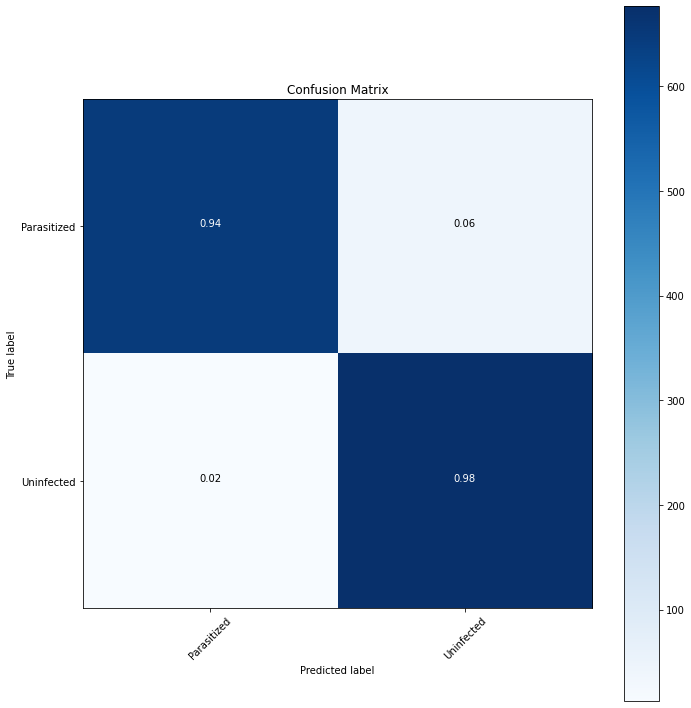

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

target_names_pre = []

for key in training_set.class_indices:

    target_names_pre.append(key)


print(target_names_pre)


Y_pred_pre = pre_trained_model.predict_generator(test_set)

y_pred_pre = np.where(Y_pred_pre>0.5, 1, 0)

print('Confusion Matrix')

cm_pre = confusion_matrix(test_set.classes, y_pred_pre)
plot_confusion_matrix(cm_pre, target_names_pre, title='Confusion Matrix')

# Part 4-Classification report

In [ ]:
report = classification_report(test_set.classes, y_pred_pre, target_names=target_names_pre)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.98      0.94      0.96       689
  Uninfected       0.94      0.98      0.96       689

    accuracy                           0.96      1378
   macro avg       0.96      0.96      0.96      1378
weighted avg       0.96      0.96      0.96      1378



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set.classes, y_pred_pre)

0.9600870827285921

##### The accuracy of the efficient on the dataset is 96.00% which is 0.73% less than our model accuracy.

# Part 5-Model accuracy and loss graphs

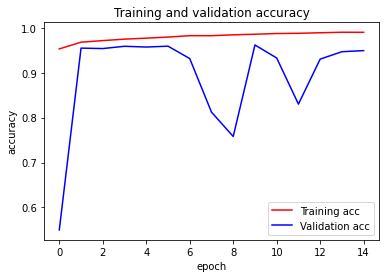

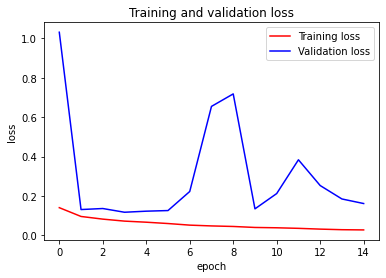

In [ ]:
import matplotlib.pyplot as plt
#Graphing our training and validation


acc = results_pre.history['accuracy']
val_acc = results_pre.history['val_accuracy']
loss = results_pre.history['loss']
val_loss = results_pre.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()



# Part 6 - Saving and Loading the model for prediction

In [ ]:
# serialize model to JSON
model_json = pre_trained_model.to_json()
with open("/content/best_Model_weights.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# load json and create model
json_file = open('/content/best_Model_weights.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('best_Model_weights.h5')

# Part 7 - Deploying the model to Predict a single sample.

In [ ]:
def read_image(file_path):

   print(“[INFO] loading and preprocessing image…”) 
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image)

   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image


def test_single_image(path):

  Outputs = ['Parasitized', 'Uninfected']
  images = read_image(path)
  time.sleep(.5)


  bt_prediction = pre_trained_model.predict(images) 
  preds = model.predict_proba(bt_prediction)

  for idx, y, x in zip(range(0,6), Outputs , preds[0]):
   print(“ID: {}, Label: {} {}%”.format(idx, y, round(x*100,2) ))
   
  print(‘Final Decision:’)
  time.sleep(.5)


  for x in range(3):
   print(‘.’*(x+1))
   time.sleep(.2)

  class_predicted = pre_trained_model.predict_classes(bt_prediction)
  class_dictionary = generator_top.class_indices 

  inv_map = {v: k for k, v in class_dictionary.items()} 
  print(“ID: {}, Label: {}”.format(class_predicted[0],  inv_map[class_predicted[0]])) 
  return load_img(path)

path = ‘data/test/yourpicturename’
test_single_image(path)

# Section 2.2   VGG16

## Part 1- VGG16: Initialising the model

In [ ]:
pre_trained_model_Vgg =tf.keras.models.Sequential([
  tf.keras.layers.InputLayer((224,224,3)),
  tf.keras.applications.VGG16(include_top=False,weights= 'imagenet', input_shape=(224,224,3)),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512,activation='relu'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024,activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [ ]:
pre_trained_model_Vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 15,503,681
Trainable params: 15,503,681
Non-trainable params: 0
_________________________________________________________________


# Part 2- Compiling and trainig the model

In [ ]:
pre_trained_model_Vgg.compile(optimizer =tf.keras.optimizers.Adam(0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
filepath = '/content/best_Model_weights.h5'
checkpoint_pre_vgg = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='auto')

In [ ]:
results_pre_vgg = pre_trained_model_Vgg.fit(x = training_set, validation_data = val_set, epochs = 15, callbacks=checkpoint_pre_vgg)

Epoch 1/15
689/689 [==============================] - 663s 893ms/step - loss: 0.1607 - accuracy: 0.9502 - val_loss: 0.1337 - val_accuracy: 0.9528

Epoch 00001: val_accuracy improved from -inf to 0.95283, saving model to /content/best_Model_weights.h5
Epoch 2/15
689/689 [==============================] - 596s 865ms/step - loss: 0.1291 - accuracy: 0.9597 - val_loss: 0.1152 - val_accuracy: 0.9606

Epoch 00002: val_accuracy improved from 0.95283 to 0.96057, saving model to /content/best_Model_weights.h5
Epoch 3/15
689/689 [==============================] - 595s 863ms/step - loss: 0.1212 - accuracy: 0.9631 - val_loss: 0.1189 - val_accuracy: 0.9589

Epoch 00003: val_accuracy did not improve from 0.96057
Epoch 4/15
689/689 [==============================] - 595s 863ms/step - loss: 0.1128 - accuracy: 0.9634 - val_loss: 0.1057 - val_accuracy: 0.9625

Epoch 00004: val_accuracy improved from 0.96057 to 0.96251, saving model to /content/best_Model_weights.h5
Epoch 5/15
689/689 [===================

## Part 3 - Plotting Graphical Confusion Matrix

['Parasitized', 'Uninfected']


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


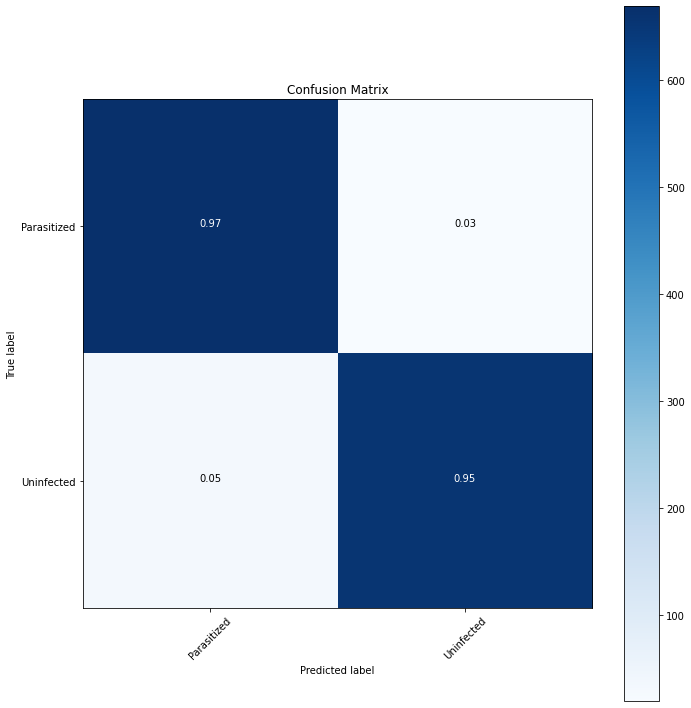

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

target_names_pre_vgg = []

for key in training_set.class_indices:

    target_names_pre_vgg.append(key)


print(target_names_pre_vgg)


Y_pred_pre_vgg = pre_trained_model_Vgg.predict_generator(test_set)

y_pred_pre_vgg = np.where(Y_pred_pre_vgg>0.5, 1, 0)

print('Confusion Matrix')

cm_pre_vgg = confusion_matrix(test_set.classes, y_pred_pre_vgg)

plot_confusion_matrix(cm_pre_vgg, target_names_pre_vgg, title='Confusion Matrix')

# Part 4-Classification report

In [ ]:
report_vgg = classification_report(test_set.classes, y_pred_pre_vgg, target_names=target_names_pre_vgg)
print(report_vgg)

              precision    recall  f1-score   support

 Parasitized       0.95      0.97      0.96       689
  Uninfected       0.97      0.95      0.96       689

    accuracy                           0.96      1378
   macro avg       0.96      0.96      0.96      1378
weighted avg       0.96      0.96      0.96      1378



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set.classes, y_pred_pre)

0.9600870827285921

# Part 5-Model accuracy and loss graphs

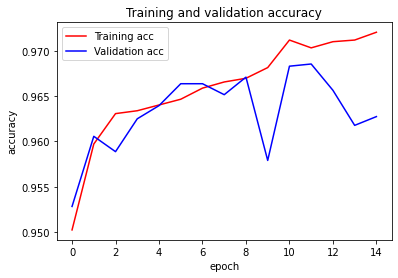

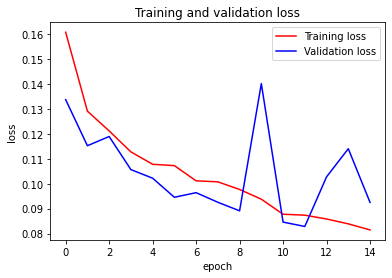

In [ ]:
import matplotlib.pyplot as plt
#Graphing our training and validation


acc = results_pre_vgg.history['accuracy']
val_acc = results_pre_vgg.history['val_accuracy']
loss = results_pre_vgg.history['loss']
val_loss = results_pre_vgg.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()



# Part 6 - Saving and Loading the model for prediction

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

In [ ]:
# serialize model to JSON
model_json = pre_trained_model_Vgg.to_json()
with open("/content/best_Model_weights.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load json and create model
json_file = open('/content/best_Model_weights.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('best_Model_weights.h5')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(test_set, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 97.02%


###### The Vgg16 model achievd accuracy 97.02% and showed the best performance.

# Part 7 - Deploying the model to Predict a single sample.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Helper libraries

def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = pre_trained_model_Vgg.predict(img_preprocessed)

    print(decode_predictions(prediction, top=3)[0])

classify("./samples/112_malaria.jpg")